In [1]:
from src.components.nn_data_ingestion import FraudDetectionDataset
from src.components.data_ingestion import DataIngestorFactory, DataIngestorConfig
from torch.utils.data import DataLoader,Dataset
from pytorch_lightning.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint  # Updated import
from src.components.utils import setup_logger, seed_everything
from src.components.exception import CustomException
from src.components.features_engineering import PreprocessorPipeline
import pandas as pd
import os
import matplotlib.pyplot as plt



In [2]:

os.chdir(rf"c:\Users\thuhi\workspace\fraud_detection")
print(os.getcwd())

factory = DataIngestorFactory()
ingestor = factory.create_ingestor("duration_pkl")
train_df, validation_df = ingestor.ingest(
    dir_path=rf"C:\Users\thuhi\workspace\fraud_detection\data\transformed_upsampled_data",
    start_train_date="2018-04-01",
    train_duration=0,
    test_duration="all",
    delay=0
)



c:\Users\thuhi\workspace\fraud_detection
2025-06-25 09:28:31,986 - INFO - train_duration is 0
2025-06-25 09:28:31,987 - INFO - test_duration is all
2025-06-25 09:28:49,215 - WARNING - train_df is empty or None


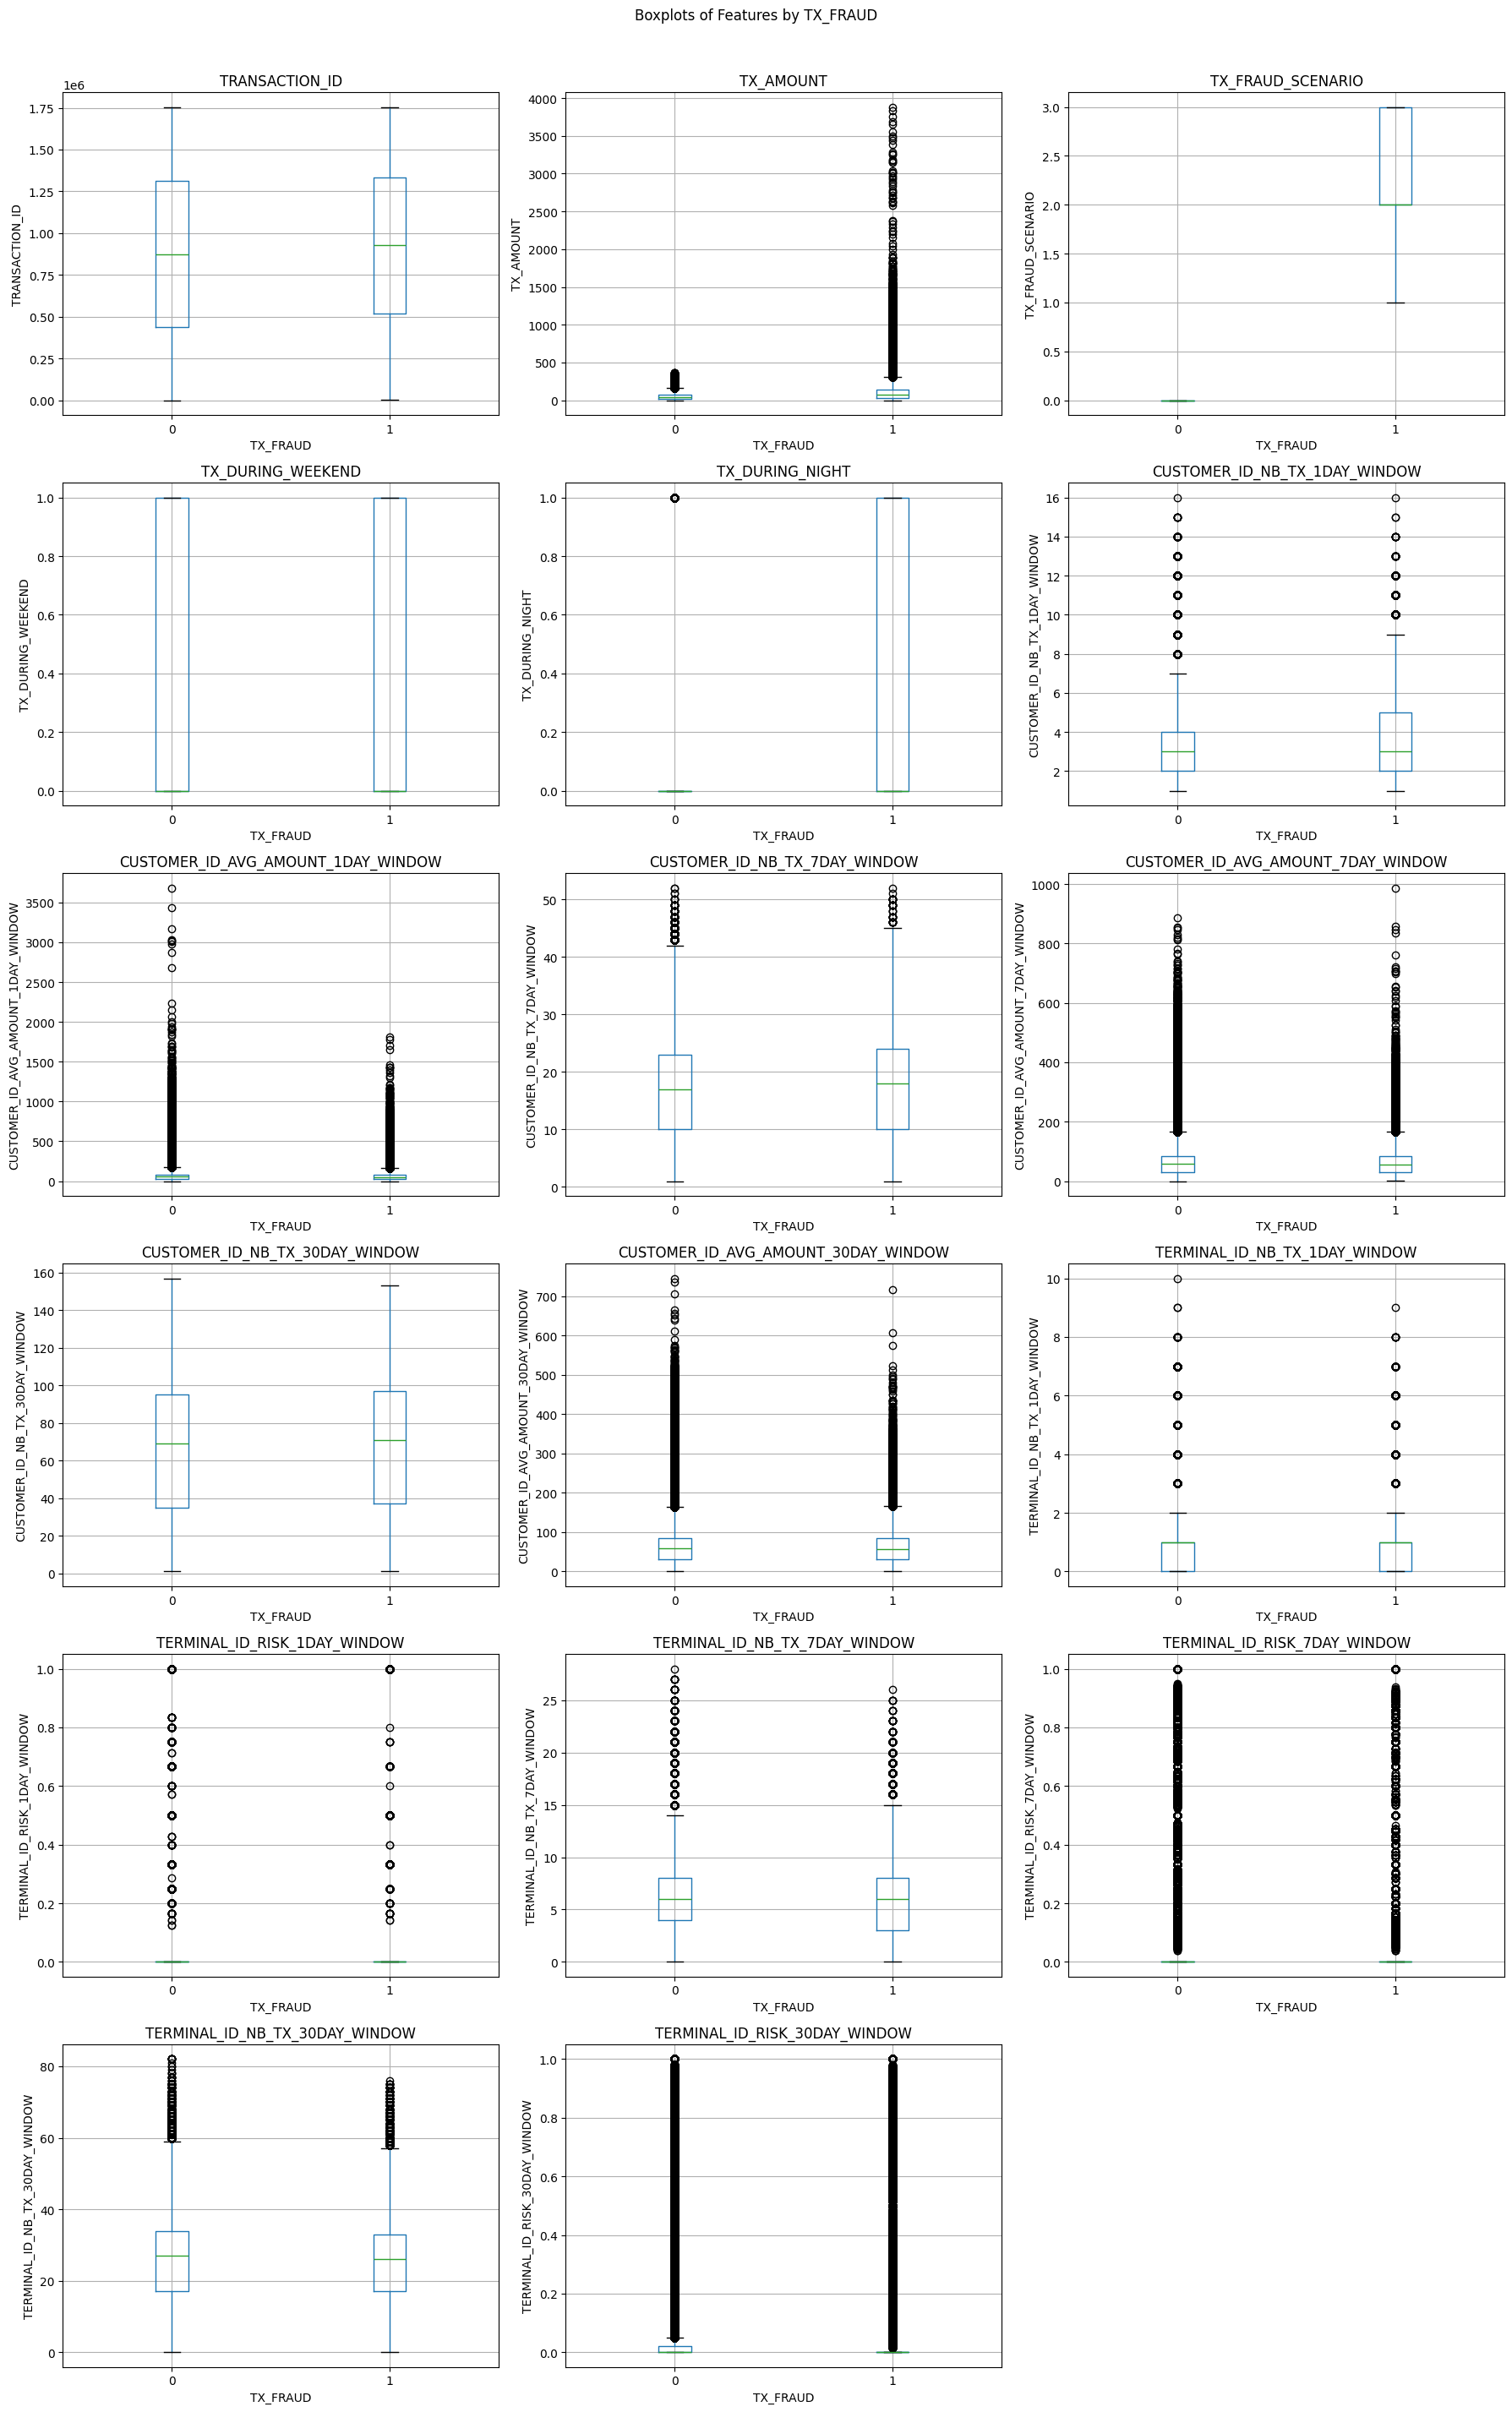

In [ ]:


# Exclude non-numeric columns and 'TX_FRAUD' itself from features to plot
features = [col for col in validation_df.columns if col not in ['TX_FRAUD'] and pd.api.types.is_numeric_dtype(validation_df[col])]

n_features = len(features)
fig, axes = plt.subplots(nrows=(n_features + 2) // 3, ncols=3, figsize=(18, 5 * ((n_features + 2) // 3)))
axes = axes.flatten()

for i, feature in enumerate(features):
    validation_df.boxplot(column=feature, by='TX_FRAUD', ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('TX_FRAUD')
    axes[i].set_ylabel(feature)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Boxplots of Features by TX_FRAUD')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

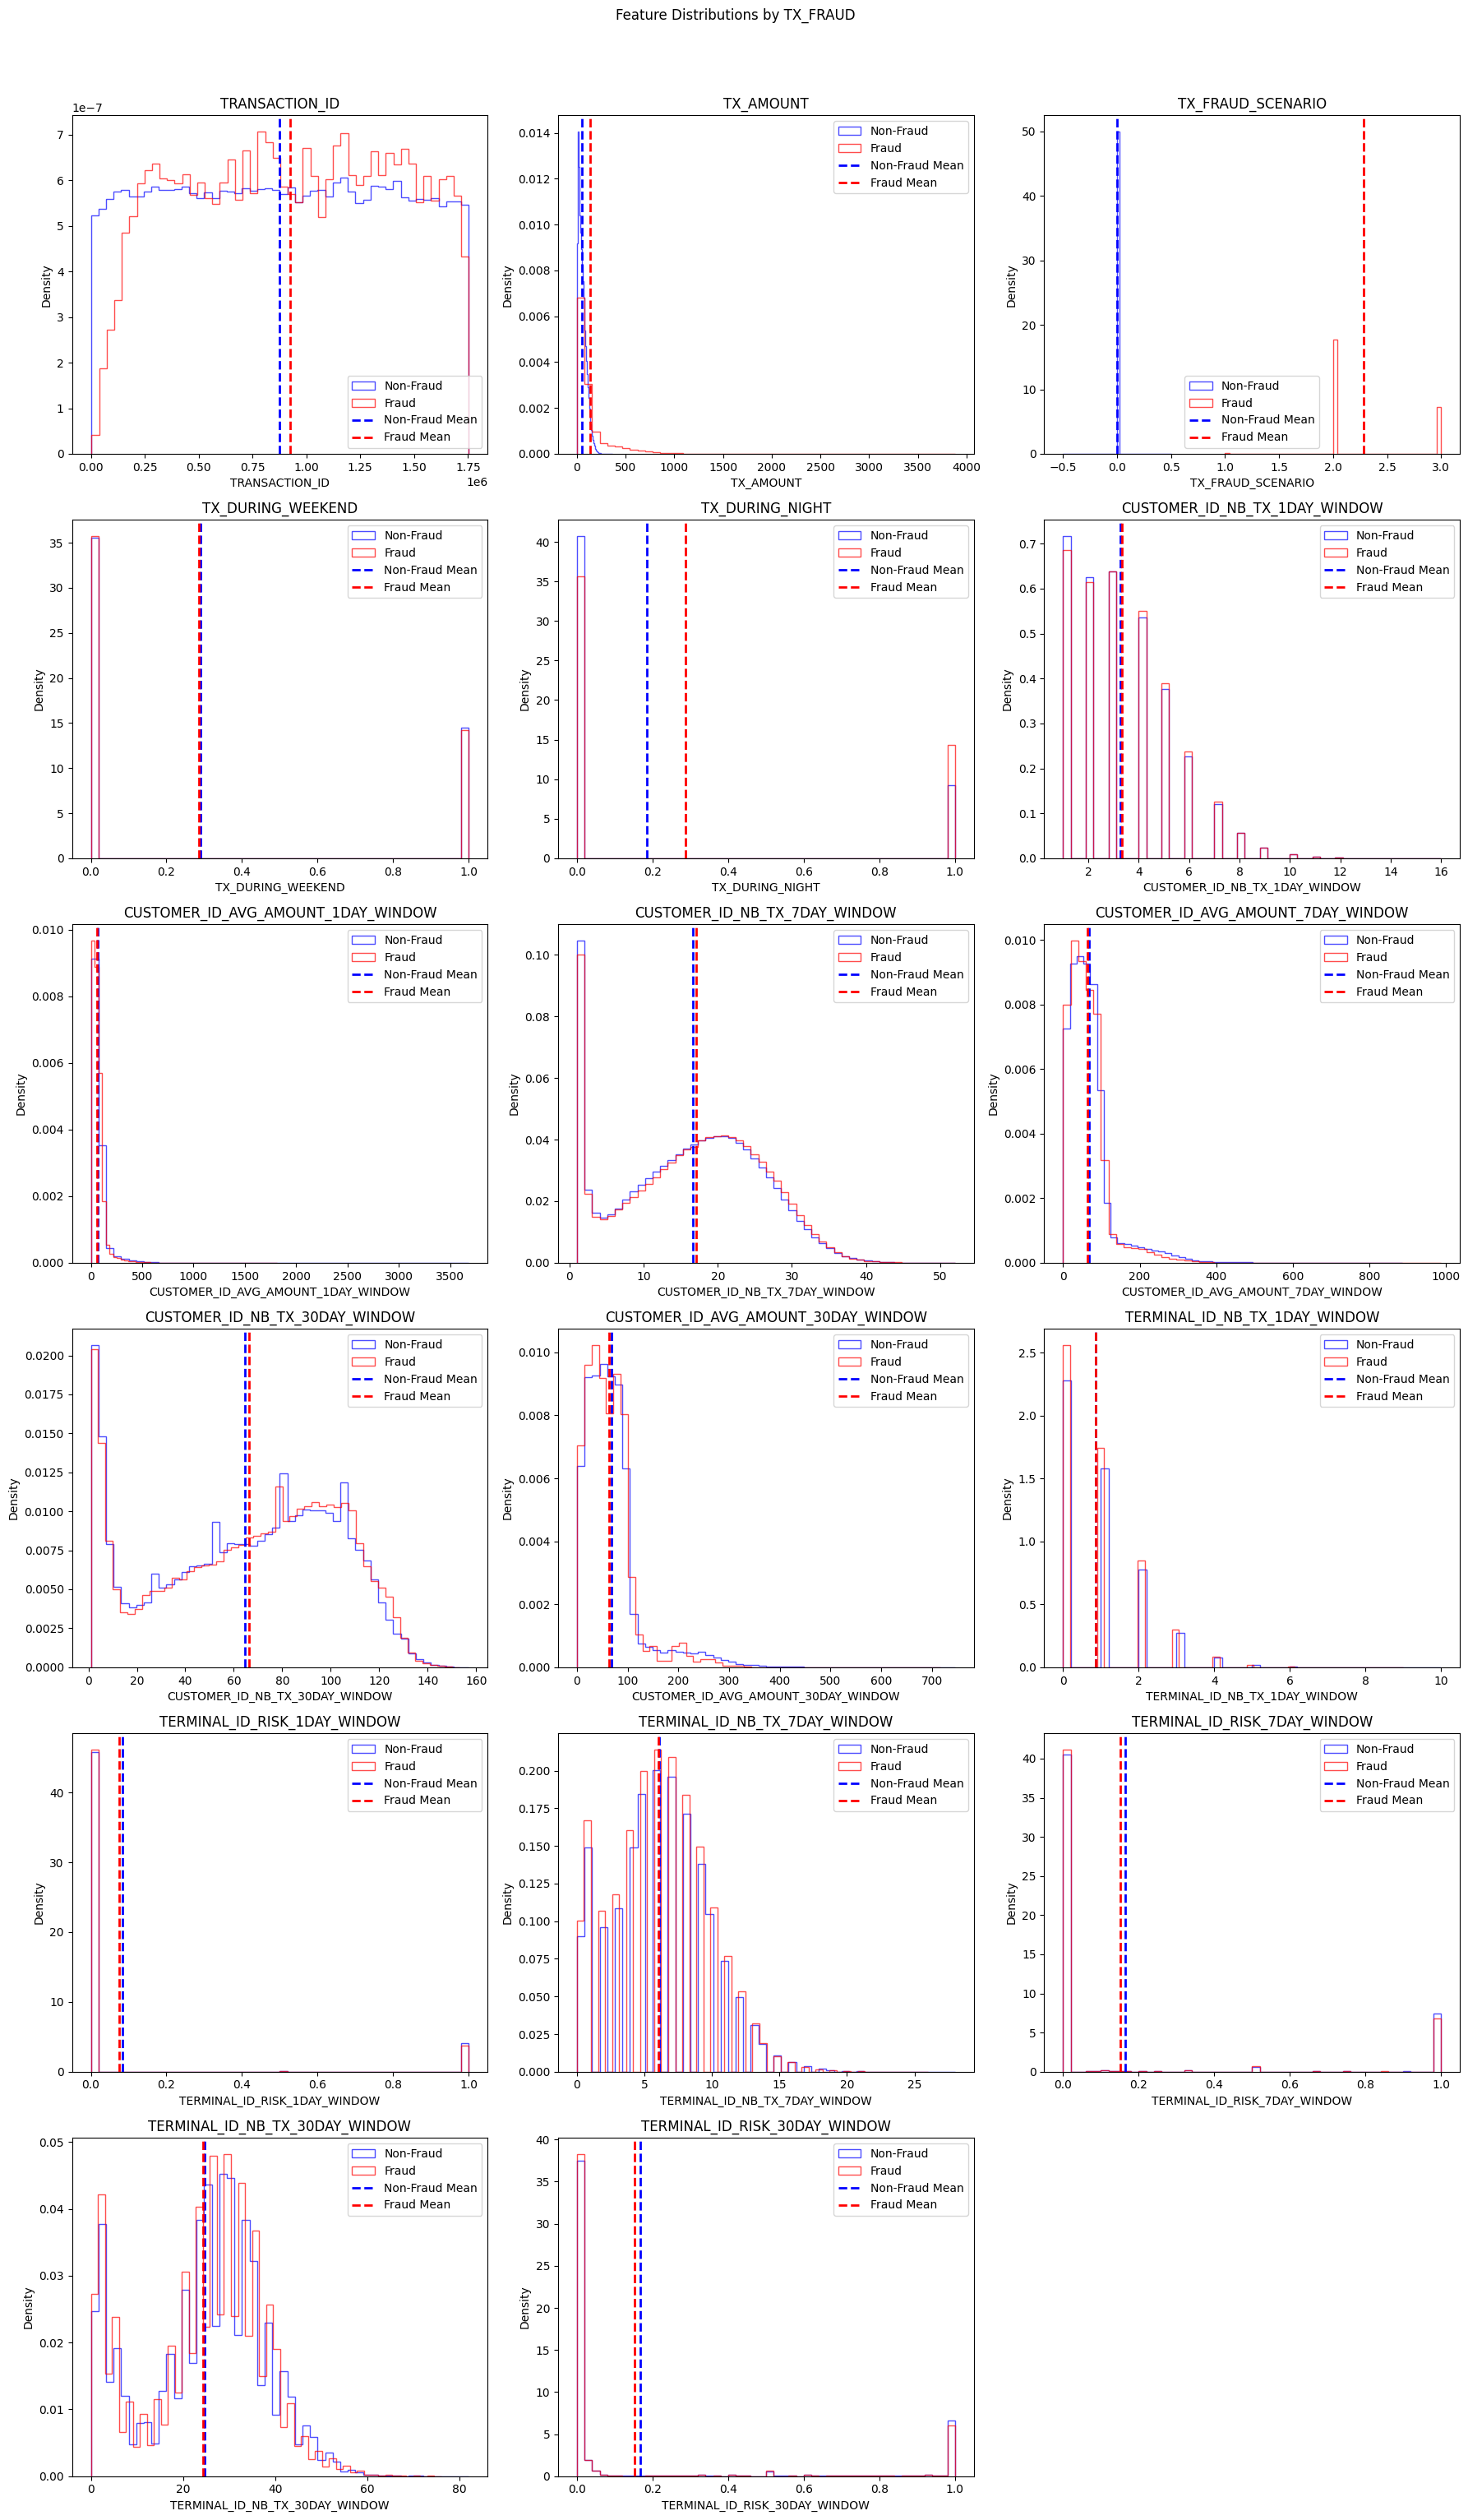

In [ ]:
import numpy as np

n_features = len(features)
fig, axes = plt.subplots(nrows=(n_features + 2) // 3, ncols=3, figsize=(18, 5 * ((n_features + 2) // 3)))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    # Plot distribution for non-fraud
    nonfraud = validation_df[validation_df['TX_FRAUD'] == 0][feature].dropna()
    fraud = validation_df[validation_df['TX_FRAUD'] == 1][feature].dropna()
    # Plot histograms as density lines
    ax.hist(nonfraud, bins=50, density=True, histtype='step', color='blue', label='Non-Fraud', alpha=0.7)
    ax.hist(fraud, bins=50, density=True, histtype='step', color='red', label='Fraud', alpha=0.7)
    # Mark means
    ax.axvline(nonfraud.mean(), color='blue', linestyle='--', linewidth=2, label='Non-Fraud Mean')
    ax.axvline(fraud.mean(), color='red', linestyle='--', linewidth=2, label='Fraud Mean')
    ax.set_title(feature)
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Feature Distributions by TX_FRAUD', y=1.02)
plt.tight_layout()
plt.show()

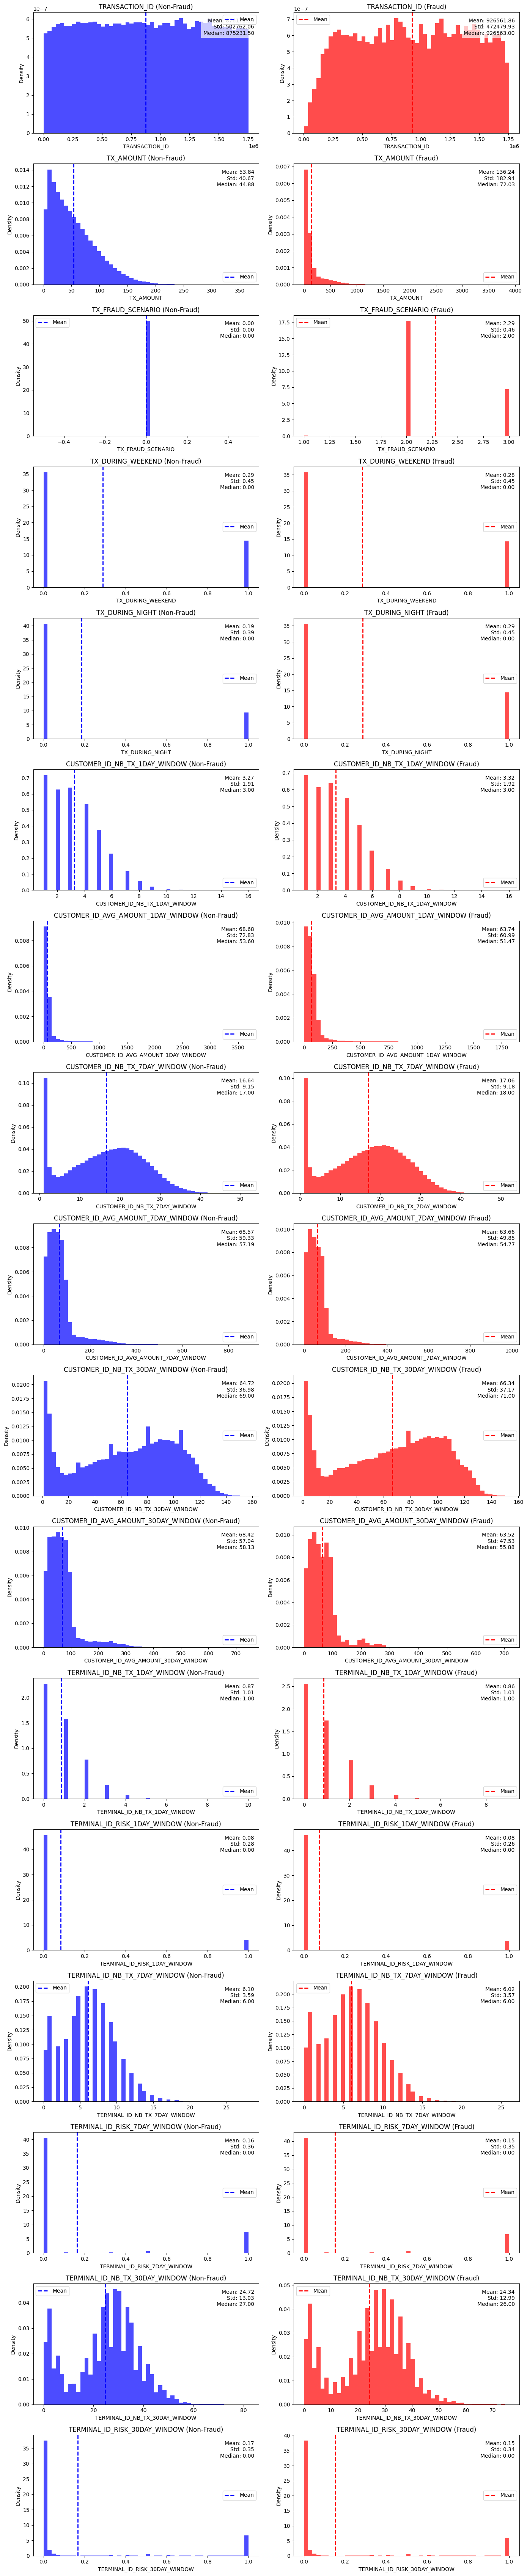

In [ ]:
# Define the most important features (example: top 3)
important_features = ['TX_AMOUNT', 'TX_FRAUD_SCENARIO', 'TERMINAL_ID_RISK_30DAY_WINDOW']

n_features = len(features)
fig, axes = plt.subplots(nrows=n_features, ncols=2, figsize=(14, 4 * n_features))
if n_features == 1:
    axes = axes.reshape(1, 2)

for i, feature in enumerate(features):
    # Non-fraud
    ax0 = axes[i, 0]
    nonfraud = validation_df[validation_df['TX_FRAUD'] == 0][feature].dropna()
    ax0.hist(nonfraud, bins=50, density=True, color='blue', alpha=0.7)
    ax0.axvline(nonfraud.mean(), color='blue', linestyle='--', linewidth=2, label='Mean')
    # Annotate statistics
    stats_nf = f"Mean: {nonfraud.mean():.2f}\nStd: {nonfraud.std():.2f}\nMedian: {nonfraud.median():.2f}"
    ax0.text(0.98, 0.95, stats_nf, transform=ax0.transAxes, fontsize=10,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    # Bold title if important

    ax0.set_title(f'{feature} (Non-Fraud)')
    ax0.set_xlabel(feature)
    ax0.set_ylabel('Density')
    ax0.legend()

    # Fraud
    ax1 = axes[i, 1]
    fraud = validation_df[validation_df['TX_FRAUD'] == 1][feature].dropna()
    ax1.hist(fraud, bins=50, density=True, color='red', alpha=0.7)
    ax1.axvline(fraud.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    # Annotate statistics
    stats_f = f"Mean: {fraud.mean():.2f}\nStd: {fraud.std():.2f}\nMedian: {fraud.median():.2f}"
    ax1.text(0.98, 0.95, stats_f, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    ax1.set_title(f'{feature} (Fraud)')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Density')
    ax1.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
import sys
class BaggingSequentialFraudDetectionDataset(Dataset):
    def __init__(self, df: pd.DataFrame, c_seq_len=14,t_seq_len=28):
        try:
            self.config = DataIngestorConfig()
            
            self.t_historical_len = t_seq_len - 1
            self.c_historical_len = c_seq_len - 1
            self.df_source = df.copy().sort_values("TX_DATETIME").reset_index(drop=True)
            self.num_samples = len(self.df_source)

            # --- 1. Prepare Target and Current Transaction Features ---
            self.targets = torch.tensor(self.df_source[self.config.output_feature].values, dtype=torch.int8)
            # The "current" stream gets all transformed features
            self.current_tx_features = torch.tensor(self.df_source[self.config.input_features_transformed].values, dtype=torch.float32)

            # --- 2. Prepare Customer History Stream ---
            self.customer_features_tensor = torch.tensor(self.df_source[self.config.input_features_customer].values, dtype=torch.float32)
            cust_padding = torch.zeros(1, self.customer_features_tensor.shape[1], dtype=torch.float32)
            self.customer_features_pool = torch.vstack([self.customer_features_tensor, cust_padding])
            cust_padding_idx = len(self.customer_features_pool) - 1

            # --- 3. Prepare Terminal History Stream ---
            self.terminal_features_tensor = torch.tensor(self.df_source[self.config.input_features_terminal].values, dtype=torch.float32)
            term_padding = torch.zeros(1, self.terminal_features_tensor.shape[1], dtype=torch.float32)
            self.terminal_features_pool = torch.vstack([self.terminal_features_tensor, term_padding])
            term_padding_idx = len(self.terminal_features_pool) - 1

            # --- 4. Create Index Mappings for Both History Types ---
            df_for_indices = pd.DataFrame({
                'CUSTOMER_ID': self.df_source['CUSTOMER_ID'],
                'TERMINAL_ID': self.df_source['TERMINAL_ID'],
                'tmp_idx': np.arange(self.num_samples)
            })

            # Customer history indices (looks back 1 to `historical_len` steps)
            cust_groupby = df_for_indices.groupby('CUSTOMER_ID')
            cust_sequences = {f"tx_{i}": cust_groupby['tmp_idx'].shift(i) for i in range(1, self.c_historical_len + 1)}
            self.customer_indices = torch.tensor(pd.DataFrame(cust_sequences).fillna(cust_padding_idx).values, dtype=torch.long)
            
            # Terminal history indices (looks back 1 to `historical_len` steps)
            term_groupby = df_for_indices.groupby('TERMINAL_ID')
            term_sequences = {f"tx_{i}": term_groupby['tmp_idx'].shift(i) for i in range(1, self.t_historical_len + 1)}
            self.terminal_indices = torch.tensor(pd.DataFrame(term_sequences).fillna(term_padding_idx).values, dtype=torch.long)
            self.df_for_indices = df_for_indices
        
        except Exception as e:
            raise CustomException(e, sys)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        # --- Assemble Customer History ---
        cust_hist_indices = self.customer_indices[index]
        customer_history_seq = self.customer_features_pool[cust_hist_indices]

        # --- Assemble Terminal History ---
        term_hist_indices = self.terminal_indices[index]
        terminal_history_seq = self.terminal_features_pool[term_hist_indices]

        # --- Get Current Transaction Info ---
        current_tx = self.current_tx_features[index]

        # --- Get Target Label ---
        target = self.targets[index]
        target = self.targets[cust_hist_indices],self.targets[term_hist_indices],self.targets[index]
        return (customer_history_seq, terminal_history_seq, current_tx), target
datab = BaggingSequentialFraudDetectionDataset(df = validation_df,c_seq_len=7,t_seq_len=7)


In [8]:
datab.df_source

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,0,2018-04-01 00:00:31.000000000,596,3156,57.160000,31,0,0,0,1,...,1.0,123.590000,1.0,123.590000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2018-04-01 00:02:10.000000000,4961,3412,81.510000,130,0,0,0,1,...,2.0,100.465000,2.0,100.465000,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2018-04-01 00:07:56.000000000,2,1365,146.000000,476,0,0,0,1,...,3.0,82.480000,3.0,82.480000,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2018-04-01 00:09:29.000000000,4128,8737,64.490000,569,0,0,0,1,...,4.0,75.540000,4.0,75.540000,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2018-04-01 00:10:34.000000000,927,9906,50.990000,634,0,0,0,1,...,5.0,73.092000,5.0,73.092000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2317040,482579,2033-07-21 04:05:40.299972395,1638,7088,63.038680,4349452,50,0,0,0,...,19.0,68.028947,75.0,69.723600,3.0,0.0,6.0,0.0,26.0,0.0
2317041,492582,2033-07-22 22:33:27.683865980,1638,4552,44.495714,4438701,51,0,0,0,...,20.0,65.667500,76.0,69.079868,1.0,0.0,8.0,0.0,28.0,0.0
2317042,509488,2033-07-23 08:51:35.069662813,1638,293,64.591056,4595213,53,1,2,1,...,16.0,56.016250,79.0,67.890380,1.0,0.0,7.0,0.0,27.0,0.0
2317043,497163,2033-07-23 11:45:16.602030164,1638,2781,68.082340,4463178,51,0,0,1,...,19.0,69.327895,77.0,68.896623,1.0,0.0,7.0,0.0,27.0,0.0


In [9]:
cust_groupby = datab.df_for_indices.groupby('CUSTOMER_ID')
cust_sequences = {f"tx_{i}": cust_groupby['tmp_idx'].shift(i) for i in range(1, 7 + 1)}
customer_indices = torch.tensor(pd.DataFrame(cust_sequences).fillna(2249914).values, dtype=torch.long)

In [10]:
csq = pd.DataFrame(cust_sequences)


In [11]:
cust_groupby = datab.df_for_indices.groupby('TERMINAL_ID')
cust_sequences = {f"tx_{i}": cust_groupby['tmp_idx'].shift(i) for i in range(1, 7 + 1)}
customer_indices = torch.tensor(pd.DataFrame(cust_sequences).fillna(2249914).values, dtype=torch.long)

In [12]:
tsq = pd.DataFrame(cust_sequences)
tsq

,tx_1,tx_2,tx_3,tx_4,tx_5,tx_6,tx_7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2317040,2317030.0,2317015.0,2317009.0,2316998.0,2316989.0,2316978.0,2316968.0
2317041,2317031.0,2317021.0,2317011.0,2317002.0,2316991.0,2316981.0,2316972.0
2317042,2317039.0,2317033.0,2317028.0,2317027.0,2317016.0,2317014.0,2317010.0
2317043,2317032.0,2317023.0,2317012.0,2317000.0,2316992.0,2316982.0,2316971.0


In [14]:
# In your nn_data_ingestion.py

class BaggingSequentialDataset(Dataset):
    def __init__(self, df: pd.DataFrame, seq_len=7, mode='train'):
        # mode can be 'train', 'eda_features', or 'eda_labels'
        self.mode = mode
        self.config = DataIngestorConfig()
        self.seq_len = seq_len
        self.historical_len = seq_len - 1

        df_source = df.copy().sort_values("TX_DATETIME").reset_index(drop=True)
        self.num_samples = len(df_source)
        
        # --- Prepare all necessary tensors ---
        self.targets = torch.tensor(df_source[self.config.output_feature].values, dtype=torch.int8)
        
        # We need pools for customer and terminal features
        customer_features_tensor = torch.tensor(df_source[self.config.input_features_customer].values, dtype=torch.float32)
        cust_padding = torch.zeros(1, customer_features_tensor.shape[1], dtype=torch.float32)
        self.customer_features_pool = torch.vstack([customer_features_tensor, cust_padding])
        cust_padding_idx = len(self.customer_features_pool) - 1

        terminal_features_tensor = torch.tensor(df_source[self.config.input_features_terminal].values, dtype=torch.float32)
        term_padding = torch.zeros(1, terminal_features_tensor.shape[1], dtype=torch.float32)
        self.terminal_features_pool = torch.vstack([terminal_features_tensor, term_padding])
        term_padding_idx = len(self.terminal_features_pool) - 1
        
        # --- Create Index Mappings ---
        df_for_indices = pd.DataFrame({
            'CUSTOMER_ID': df_source['CUSTOMER_ID'],
            'TERMINAL_ID': df_source['TERMINAL_ID'],
            'tmp_idx': np.arange(self.num_samples)
        })

        cust_groupby = df_for_indices.groupby('CUSTOMER_ID')
        cust_sequences = {f"tx_{i}": cust_groupby['tmp_idx'].shift(i) for i in range(1, self.historical_len + 1)}
        self.customer_indices = torch.tensor(pd.DataFrame(cust_sequences).fillna(cust_padding_idx).values, dtype=torch.long)
        
        term_groupby = df_for_indices.groupby('TERMINAL_ID')
        term_sequences = {f"tx_{i}": term_groupby['tmp_idx'].shift(i) for i in range(1, self.historical_len + 1)}
        self.terminal_indices = torch.tensor(pd.DataFrame(term_sequences).fillna(term_padding_idx).values, dtype=torch.long)
        
        # --- Unused unless in 'train' mode ---
        self.current_tx_features = torch.empty(0)
        
        print(f"BaggingSequentialDataset initialized in '{self.mode}' mode.")

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        if self.mode == 'eda_features':
            # For this EDA, we want the sequence of historical FEATURE VECTORS
            cust_hist_indices = self.customer_indices[index]
            customer_history_features = self.customer_features_pool[cust_hist_indices]

            term_hist_indices = self.terminal_indices[index]
            terminal_history_features = self.terminal_features_pool[term_hist_indices]

            target_label = self.targets[index]
            return customer_history_features, terminal_history_features, target_label
        
        elif self.mode == 'train':
            # Default 'train' mode logic...
            # ...
            pass
        else:
            raise NotImplementedError(f"Mode '{self.mode}' is not supported.")

INFO:__main__:Data loaded and features engineered. Total samples: 2317045


Current working directory: c:\Users\thuhi\workspace\fraud_detection


INFO:__main__:Iterating through dataset to aggregate historical feature values...


BaggingSequentialDataset initialized in 'eda_features' mode.


INFO:__main__:Aggregation complete. Generating plots...


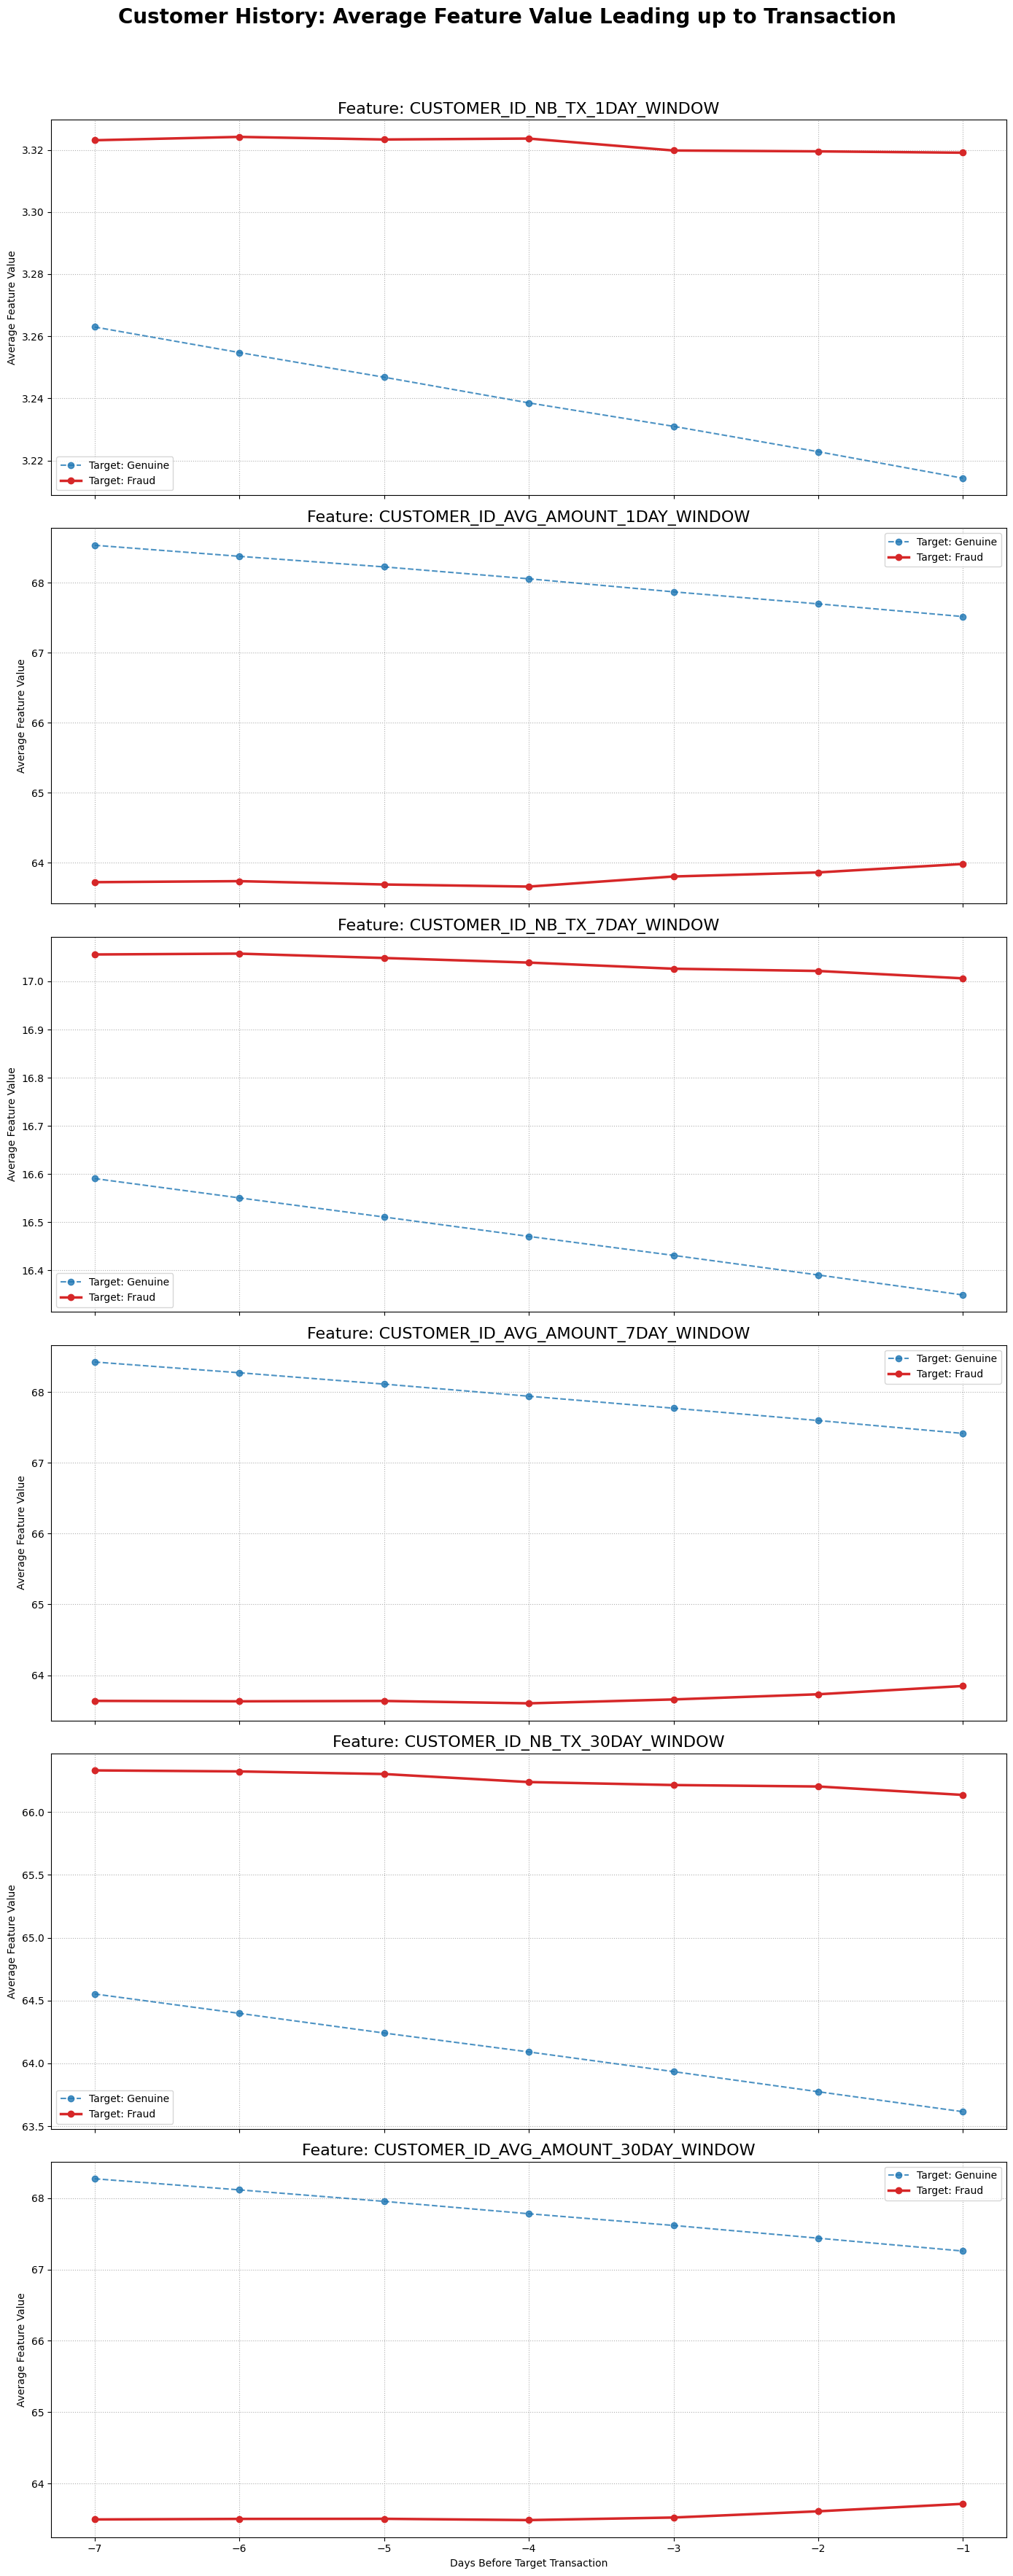

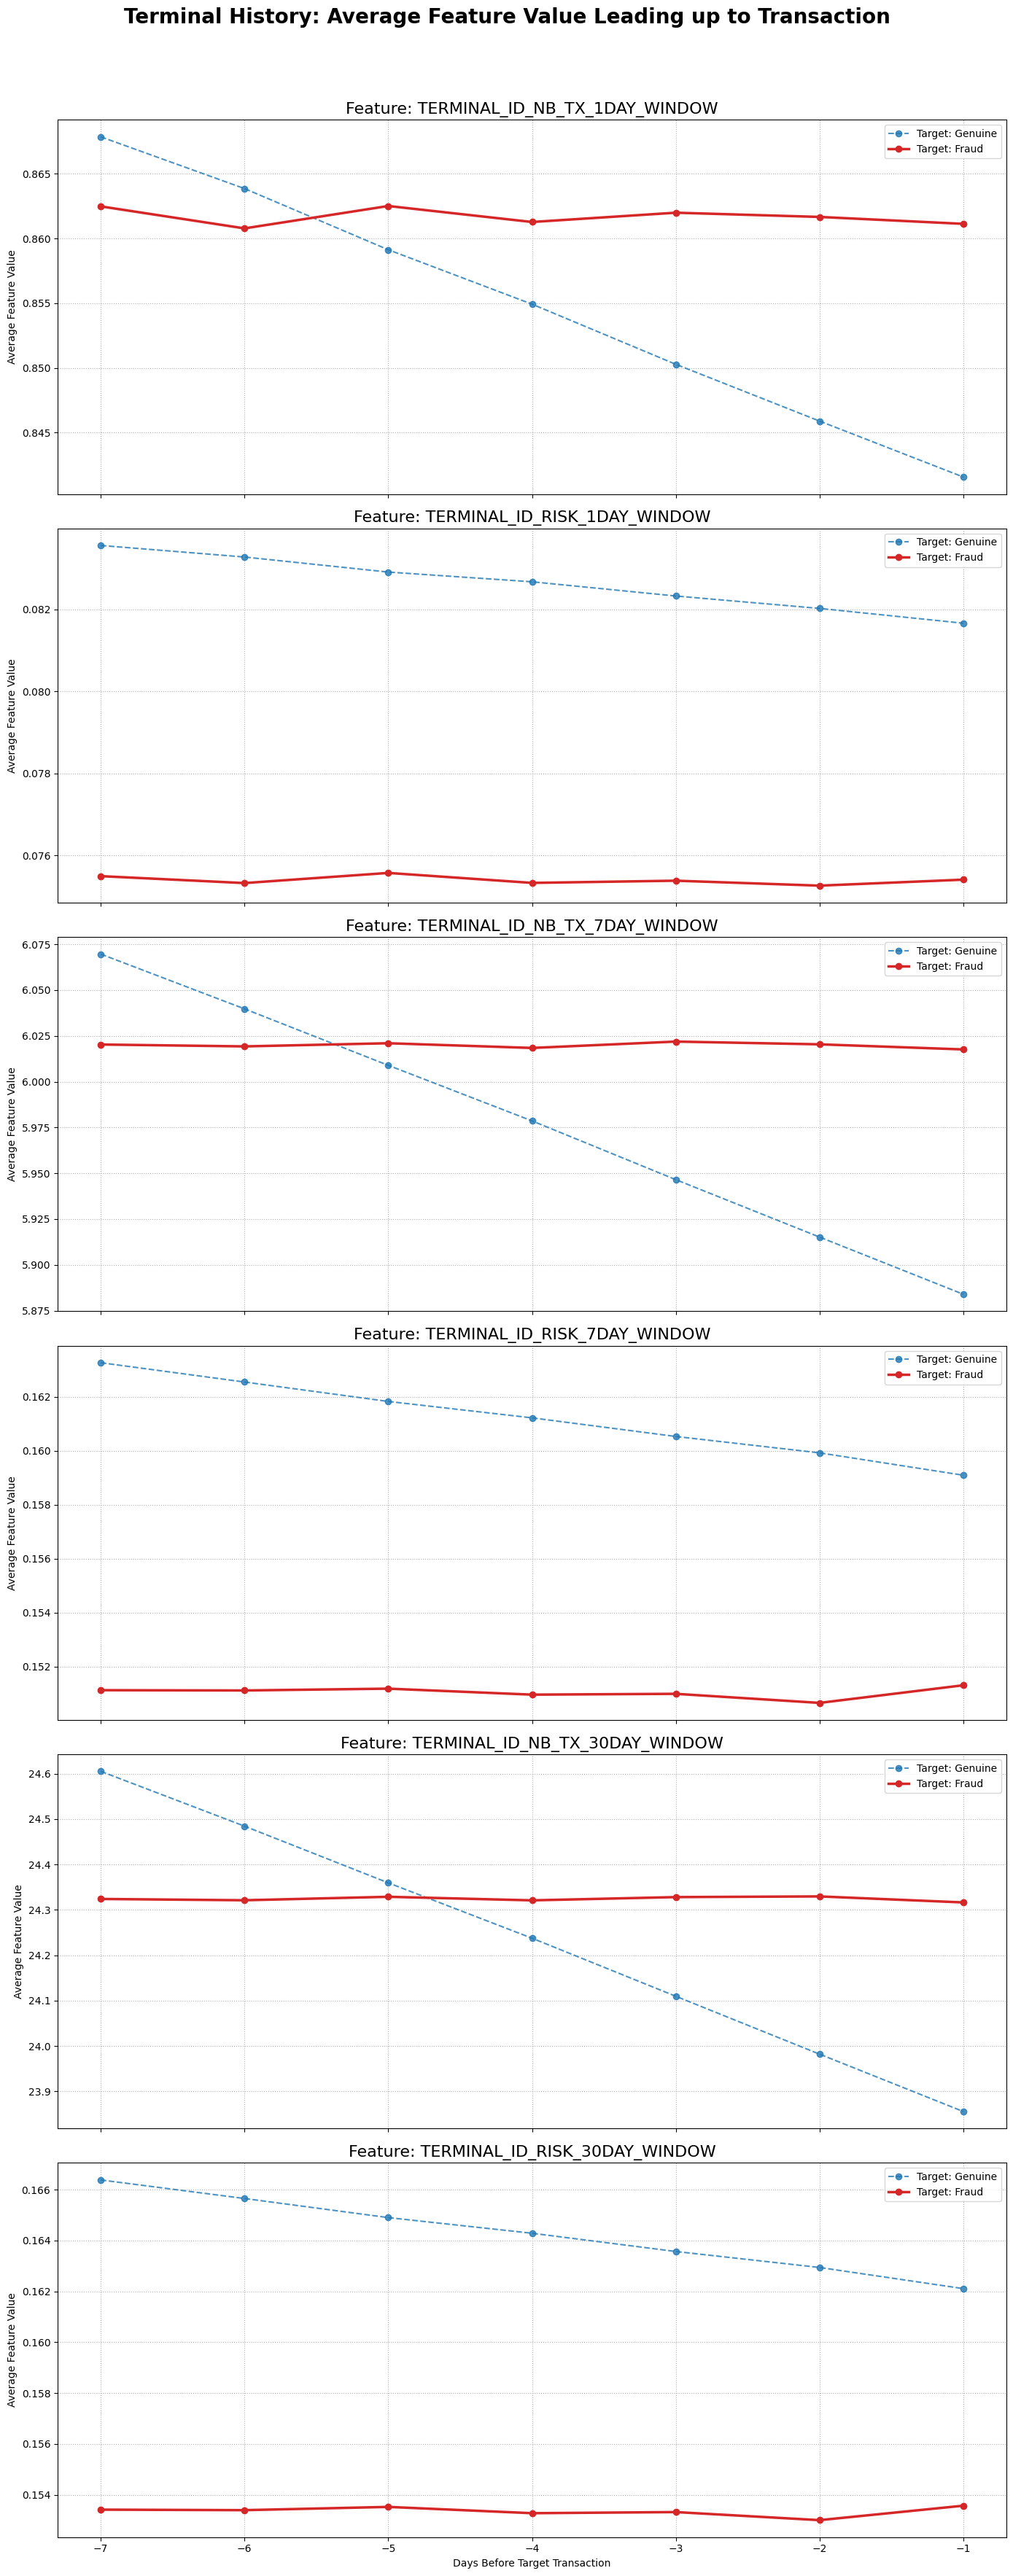

In [18]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# --- Assume these are correctly imported from your project structure ---


def setup_logger():
    import logging
    logging.basicConfig(level=logging.INFO)
    return logging.getLogger(__name__)

# ==============================================================================
# 1. DATASET DEFINITION (Configured for Feature Sequence EDA)
# ==============================================================================

class BaggingSequentialDataset(Dataset):
    """
    A special version of the dataset for EDA.
    In 'eda_features' mode, it returns the sequence of historical feature vectors.
    """
    def __init__(self, df: pd.DataFrame, seq_len=7, mode='train'):
        self.mode = mode
        self.config = DataIngestorConfig()
        self.seq_len = seq_len
        self.historical_len = seq_len - 1

        df_source = df.copy().sort_values("TX_DATETIME").reset_index(drop=True)
        self.num_samples = len(df_source)
        
        # --- Prepare all necessary tensors ---
        self.targets = torch.tensor(df_source[self.config.output_feature].values, dtype=torch.int8)
        
        customer_features_tensor = torch.tensor(df_source[self.config.input_features_customer].values, dtype=torch.float32)
        cust_padding = torch.zeros(1, customer_features_tensor.shape[1], dtype=torch.float32)
        self.customer_features_pool = torch.vstack([customer_features_tensor, cust_padding])
        cust_padding_idx = len(self.customer_features_pool) - 1

        terminal_features_tensor = torch.tensor(df_source[self.config.input_features_terminal].values, dtype=torch.float32)
        term_padding = torch.zeros(1, terminal_features_tensor.shape[1], dtype=torch.float32)
        self.terminal_features_pool = torch.vstack([terminal_features_tensor, term_padding])
        term_padding_idx = len(self.terminal_features_pool) - 1
        
        # --- Create Index Mappings ---
        df_for_indices = pd.DataFrame({
            'CUSTOMER_ID': df_source['CUSTOMER_ID'],
            'TERMINAL_ID': df_source['TERMINAL_ID'],
            'tmp_idx': np.arange(self.num_samples)
        })

        cust_groupby = df_for_indices.groupby('CUSTOMER_ID')
        cust_sequences = {f"tx_{i}": cust_groupby['tmp_idx'].shift(i) for i in range(1, self.historical_len + 1)}
        self.customer_indices = torch.tensor(pd.DataFrame(cust_sequences).fillna(cust_padding_idx).values, dtype=torch.long)
        
        term_groupby = df_for_indices.groupby('TERMINAL_ID')
        term_sequences = {f"tx_{i}": term_groupby['tmp_idx'].shift(i) for i in range(1, self.historical_len + 1)}
        self.terminal_indices = torch.tensor(pd.DataFrame(term_sequences).fillna(term_padding_idx).values, dtype=torch.long)
        
        print(f"BaggingSequentialDataset initialized in '{self.mode}' mode.")

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        if self.mode != 'eda_features':
            raise NotImplementedError("This dataset instance is configured for EDA mode only.")
            
        cust_hist_indices = self.customer_indices[index]
        customer_history_features = self.customer_features_pool[cust_hist_indices]

        term_hist_indices = self.terminal_indices[index]
        terminal_history_features = self.terminal_features_pool[term_hist_indices]

        target_label = self.targets[index]
        return customer_history_features, terminal_history_features, target_label

    # ==============================================================================
    # 2. MAIN EDA SCRIPT
    # ==============================================================================

if __name__ == "__main__":
    logger = setup_logger()
    os.chdir(rf"c:\Users\thuhi\workspace\fraud_detection")
    print(f"Current working directory: {os.getcwd()}")

    # --- Configuration ---
    SEQ_LEN = 8 # 7 days history + 1 target day
    BATCH_SIZE = 4096
    config = DataIngestorConfig()


    # For this EDA, we are analyzing the UN-SCALED features to see real values.
    # The pipeline should only calculate the windowed features.

    logger.info(f"Data loaded and features engineered. Total samples: {len(validation_df)}")

    # --- Setup Dataset and DataLoader ---
    eda_dataset = BaggingSequentialDataset(validation_df, seq_len=SEQ_LEN, mode='eda_features')
    eda_loader = DataLoader(eda_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

    # --- Data Aggregation Loop ---
    cust_feature_names = config.input_features_customer
    term_feature_names = config.input_features_terminal
    num_cust_feats = len(cust_feature_names)
    num_term_feats = len(term_feature_names)
    hist_len = SEQ_LEN - 1

    # Dictionaries to store the sum of feature vectors and sample counts
    results = {
        'Genuine': {'count': 0, 'customer_sums': torch.zeros(hist_len, num_cust_feats), 'terminal_sums': torch.zeros(hist_len, num_term_feats)},
        'Fraud':   {'count': 0, 'customer_sums': torch.zeros(hist_len, num_cust_feats), 'terminal_sums': torch.zeros(hist_len, num_term_feats)}
    }

    logger.info("Iterating through dataset to aggregate historical feature values...")
    for cust_hist_feats, term_hist_feats, target_labels in eda_loader:
        for i in range(len(target_labels)):
            target_type = 'Fraud' if target_labels[i].item() == 1 else 'Genuine'
            results[target_type]['count'] += 1
            results[target_type]['customer_sums'] += cust_hist_feats[i]
            results[target_type]['terminal_sums'] += term_hist_feats[i]

    logger.info("Aggregation complete. Generating plots...")

    # --- Calculate Averages ---
    avg_cust_genuine = results['Genuine']['customer_sums'] / results['Genuine']['count'] if results['Genuine']['count'] > 0 else torch.zeros(hist_len, num_cust_feats)
    avg_cust_fraud = results['Fraud']['customer_sums'] / results['Fraud']['count'] if results['Fraud']['count'] > 0 else torch.zeros(hist_len, num_cust_feats)
    avg_term_genuine = results['Genuine']['terminal_sums'] / results['Genuine']['count'] if results['Genuine']['count'] > 0 else torch.zeros(hist_len, num_term_feats)
    avg_term_fraud = results['Fraud']['terminal_sums'] / results['Fraud']['count'] if results['Fraud']['count'] > 0 else torch.zeros(hist_len, num_term_feats)

    time_steps = range(-(hist_len), 0, 1)

    # --- Plotting Function ---
    def plot_feature_trends(avg_genuine, avg_fraud, feature_names, title):
        num_features = len(feature_names)
        fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(14, 6 * num_features), sharex=True)
        if num_features == 1: # Make sure axes is always a list
            axes = [axes]
        
        fig.suptitle(title, fontsize=20, weight='bold')
        
        for i, feature_name in enumerate(feature_names):
            ax = axes[i]
            ax.plot(time_steps, avg_genuine[:, i], marker='o', linestyle='--', label='Target: Genuine', color='#1f77b4', alpha=0.8)
            ax.plot(time_steps, avg_fraud[:, i], marker='o', linestyle='-', label='Target: Fraud', color='#d62728', linewidth=2.5)
            ax.set_ylabel('Average Feature Value')
            ax.set_title(f'Feature: {feature_name}', fontsize=16)
            ax.grid(True, which='both', linestyle=':')
            ax.legend()
            
        axes[-1].set_xlabel('Days Before Target Transaction')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    # --- Generate Plots ---
    plot_feature_trends(avg_cust_genuine, avg_cust_fraud, cust_feature_names, 
                        'Customer History: Average Feature Value Leading up to Transaction')

    plot_feature_trends(avg_term_genuine, avg_term_fraud, term_feature_names,
                        'Terminal History: Average Feature Value Leading up to Transaction')

In [ ]:
# In your nn_data_ingestion.py

class BaggingSequentialDataset(Dataset):
    def __init__(self, df: pd.DataFrame, seq_len=7, mode='train'):
        # mode can be 'train' or 'eda'
        self.mode = mode
        self.config = DataIngestorConfig()
        self.seq_len = seq_len
        self.historical_len = seq_len - 1

        df_source = df.copy().sort_values("TX_DATETIME").reset_index(drop=True)
        self.num_samples = len(df_source)

        # --- Prepare all necessary tensors ---
        self.targets = torch.tensor(df_source[self.config.output_feature].values, dtype=torch.int8)
        self.current_tx_features = torch.tensor(df_source[self.config.input_features_transformed].values, dtype=torch.float32)

        customer_features_tensor = torch.tensor(df_source[self.config.input_features_customer].values, dtype=torch.float32)
        cust_padding = torch.zeros(1, customer_features_tensor.shape[1], dtype=torch.float32)
        self.customer_features_pool = torch.vstack([customer_features_tensor, cust_padding])
        cust_padding_idx = len(self.customer_features_pool) - 1

        terminal_features_tensor = torch.tensor(df_source[self.config.input_features_terminal].values, dtype=torch.float32)
        term_padding = torch.zeros(1, terminal_features_tensor.shape[1], dtype=torch.float32)
        self.terminal_features_pool = torch.vstack([terminal_features_tensor, term_padding])
        term_padding_idx = len(self.terminal_features_pool) - 1
        
        # We need a pool of target labels for historical lookups, including padding.
        # The padding label is 0 (non-fraud).
        self.historical_targets_pool = torch.cat([self.targets, torch.tensor([0], dtype=torch.int8)])

        # --- Create Index Mappings ---
        df_for_indices = pd.DataFrame({
            'CUSTOMER_ID': df_source['CUSTOMER_ID'],
            'TERMINAL_ID': df_source['TERMINAL_ID'],
            'tmp_idx': np.arange(self.num_samples)
        })

        cust_groupby = df_for_indices.groupby('CUSTOMER_ID')
        cust_sequences = {f"tx_{i}": cust_groupby['tmp_idx'].shift(i) for i in range(1, self.historical_len + 1)}
        self.customer_indices = torch.tensor(pd.DataFrame(cust_sequences).fillna(cust_padding_idx).values, dtype=torch.long)
        
        term_groupby = df_for_indices.groupby('TERMINAL_ID')
        term_sequences = {f"tx_{i}": term_groupby['tmp_idx'].shift(i) for i in range(1, self.historical_len + 1)}
        self.terminal_indices = torch.tensor(pd.DataFrame(term_sequences).fillna(term_padding_idx).values, dtype=torch.long)
        


    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        cust_hist_indices = self.customer_indices[index]
        term_hist_indices = self.terminal_indices[index]

        if self.mode == 'eda':
            # For EDA, we want the sequence of historical fraud labels
            customer_history_labels = self.historical_targets_pool[cust_hist_indices]
            terminal_history_labels = self.historical_targets_pool[term_hist_indices]
            target_label = self.targets[index]
            return customer_history_labels, terminal_history_labels, target_label
        
        # Default 'train' mode
        customer_history_seq = self.customer_features_pool[cust_hist_indices]
        terminal_history_seq = self.terminal_features_pool[term_hist_indices]
        current_tx = self.current_tx_features[index]
        target = self.targets[index]
        return (customer_history_seq, terminal_history_seq, current_tx), target

Iterating through dataset to aggregate historical fraud probabilities...
Aggregation complete.


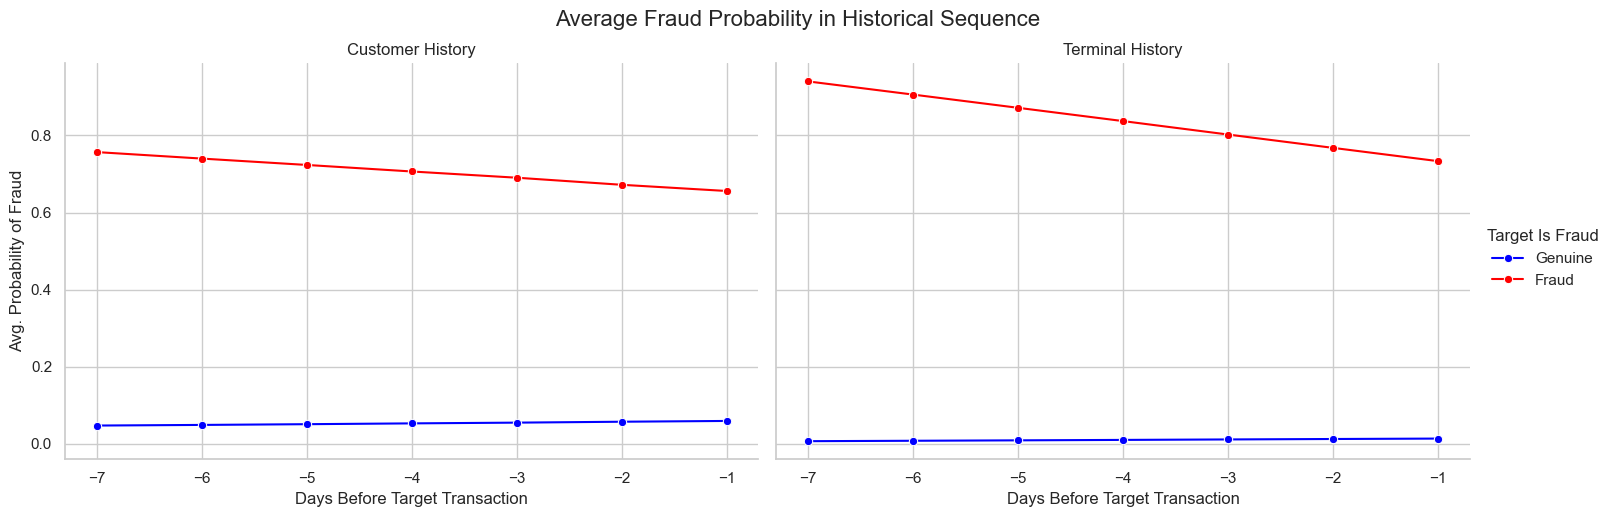

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure these are imported correctly from your project structure
# from src.baseline.data_ingestion import DataIngestorFactory
# from src.baseline.features_engineering import PreprocessorPipeline
# from src.components.nn_data_ingestion import BaggingSequentialDataset

# ==============================================================================
# 1. DATA LOADING (Same as your setup)
# ==============================================================================
# ... (your code to load train_df and validation_df) ...
# train_preprocessed = PreprocessorPipeline(train_df, add_method=["scale"]).process()
# ...
# For this example, let's assume 'train_preprocessed' is a loaded DataFrame

# ==============================================================================
# 2. SETUP DATASET AND DATALOADER FOR EDA
# ==============================================================================
# Use a smaller sequence length for easier plotting
SEQ_LEN = 8 # 7 days history + 1 target
BATCH_SIZE = 4096

# Instantiate the dataset in 'eda' mode
eda_dataset = BaggingSequentialDataset(validation_df, seq_len=SEQ_LEN, mode='eda')

eda_loader = DataLoader(
    eda_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0, # Set to 0 for Jupyter/Windows compatibility
    shuffle=False # No need to shuffle for this analysis
)

# ==============================================================================
# 3. DATA AGGREGATION LOOP
# ==============================================================================
# We will store the sum of historical frauds and the count of samples for each group
# Groups are: (target_is_fraud, history_type) where history_type is 'customer' or 'terminal'
results = {
    (False, 'customer'): {'sums': torch.zeros(SEQ_LEN - 1), 'count': 0},
    (True,  'customer'): {'sums': torch.zeros(SEQ_LEN - 1), 'count': 0},
    (False, 'terminal'): {'sums': torch.zeros(SEQ_LEN - 1), 'count': 0},
    (True,  'terminal'): {'sums': torch.zeros(SEQ_LEN - 1), 'count': 0}
}

print("Iterating through dataset to aggregate historical fraud probabilities...")

for cust_hist_labels, term_hist_labels, target_labels in eda_loader:
    for i in range(len(target_labels)):
        is_fraud = bool(target_labels[i].item())
        
        # Aggregate customer history
        results[(is_fraud, 'customer')]['sums'] += cust_hist_labels[i]
        results[(is_fraud, 'customer')]['count'] += 1
        
        # Aggregate terminal history
        results[(is_fraud, 'terminal')]['sums'] += term_hist_labels[i]
        results[(is_fraud, 'terminal')]['count'] += 1

print("Aggregation complete.")

# ==============================================================================
# 4. CALCULATE PROBABILITIES AND PLOT
# ==============================================================================
# Create a DataFrame to hold the final probabilities for plotting
plot_data = []

for (is_fraud, history_type), data in results.items():
    if data['count'] > 0:
        # Calculate the average probability of fraud for each day in the sequence
        avg_prob = data['sums'] / data['count']
        for day, prob in enumerate(avg_prob.numpy()):
            plot_data.append({
                'Days Before Target': -(SEQ_LEN - 1 - day), # e.g., -7, -6, ..., -1
                'History Type': history_type.title(),
                'Target Is Fraud': 'Fraud' if is_fraud else 'Genuine',
                'Avg. Historical Fraud Prob.': prob
            })

plot_df = pd.DataFrame(plot_data)

# --- Plotting ---
sns.set_theme(style="whitegrid")
g = sns.FacetGrid(plot_df, col="History Type", hue="Target Is Fraud", height=5, aspect=1.5,
                  palette={'Genuine': 'blue', 'Fraud': 'red'})
g.map(sns.lineplot, "Days Before Target", "Avg. Historical Fraud Prob.", marker='o')
g.add_legend()
g.fig.suptitle('Average Fraud Probability in Historical Sequence', y=1.03, fontsize=16)
g.set_axis_labels("Days Before Target Transaction", "Avg. Probability of Fraud")
g.set_titles("{col_name} History")

plt.show()